# Properties of Main Belt Asteroids in DP0.3
<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
Contact author(s): Jeff Carlin <br>
Last verified to run: 2024-12-17 <br>
LSST Science Pipelines version: Weekly 2024_50 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** An introduction to Main Belt asteroids in the DP0.3 dataset, and illustration of some simple analyses of their orbital families.

**Skills:** Use TAP queries to retrieve Solar System objects. Plot properties and orbits of Main Belt asteroids.

**LSST Data Products:** TAP DP0.3 MPCORB, SSObject, and SSSource tables.

**Packages:** lsst.rsp.get_tap_service

**Credit:** Originally developed by Jeff Carlin and the Rubin Community Science Team in the context of the Rubin DP0.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to use TAP to query the MPCORB and SSObject tables. The tables are queried simultaneously and joined on their SSObjectId, which allows one to retrieve the measured magnitudes from SSObject and orbital properties from MPCORB. We examine the properties of a large sample of Solar System objects from the DP0.3 catalogs, then focus on asteroids in the Main Belt (between about 1.6-4.2 au). We examine the orbital properties of Main Belt asteroids, and plot orbits of some of them to look for differences between the orbital families.

A detailed introduction to the DP0.3 data products can be found in Notebook DP03_01_Introduction_to_DP03.

### 1.1 Package Imports

The `matplotlib` and `numpy` libraries are widely used Python libraries for plotting and scientific computing. We will use these packages below, including the `matplotlib.pyplot` plotting sublibrary.

We also use the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service

In [ ]:
service = get_tap_service("ssotap")

### 1.2 Define Functions and Parameters

Define a function to convert a given perihelion distance (`q`) and eccentricity (`e`) to an orbital semi-major axis (`a`). Their relationship is defined by q = a(1-e).

In [ ]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
      calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: float
        Distance at perihelion, in au.
    e: float
        Orbital eccentricity.

    Returns
    -------
    a: float
        Semi-major axis of the orbit, in au.
        q = a(1-e), so a = q/(1-e)
    """

    return q / (1.0 - e)

Define a function to calculate the semi-major axis (a) at which a mean-motion resonance with a planet occurs via Kepler's Third Law: (P/P_planet)^2 = (a/a_planet)^3, where `a` is the semi-major axis of a small body in au, `a_planet` is the planet's semi-major axis in au, `P` is the small body's orbital period in yr, and `P_planet` is the planet's orbital period in yr.

In [ ]:
def calc_mean_motion_res_a(P_over_P_planet, a_planet):
    """
    
    Implements Kepler's Third law,
    `(P/P_planet)^2 = (a/a_planet)^3`, where
    `a` is the semi-major axis in au,
    `a_planet` is the planet's semi-major axis in au,
    `P` is the small body's orbital period in yr, and
    `P_planet` is the planet's orbital period in yr,
    to find the semimajor axis at which a mean-motion
    resonance with a planet occurs, via
    `a = a_planet * (P/P_planet)^(2/3)`.

    Parameters
    ----------
    P_over_P_planet: ndarray
        Integer ratio of a small body's orbital period
        to a planet's orbital period.
    a_planet: ndarray
        Semimajor axis of a planet, in au.

    Returns
    -------
    a_res: ndarray
        Semimajor axis of a mean motion resonance, in au.
        a_res = (P/P_planet)^(2/3) * a_planet
    """

    return (float(P_over_P_planet))**0.66667 * a_planet

Define a function to take an `ssObjectId` as an input, and return all measurements of that object from the `SSSource` table.

In [ ]:
def get_obj_matched(objid):
    """
    Given an objectId, retrieve all measurements from
      SSSource for that object.

    Parameters
    ----------
    objid: int64
        ObjectId of the object of interest.

    Returns
    -------
    allsrc: dataframe
        Measurements for the object from the DP0.3 SSSource table.
    """

    query = """SELECT * FROM dp03_catalogs_10yr.DiaSource as diasrc \
            JOIN dp03_catalogs_10yr.SSSource as sssrc \
            ON diasrc.diaSourceId = sssrc.diaSourceId \
            WHERE diasrc.ssObjectId = """ + str(objid)

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    assert job.phase == 'COMPLETED'

    allsrc = job.fetch_result().to_table().to_pandas()

    return allsrc

Define a function to plot orbits of multiple Solar System objects on the same figure. The orbits are plotted in XYZ Cartesian coordinates, either in a heliocentric (Sun-centered) or topocentric (relative to the Earth's surface) frame.

In [ ]:
def xyz_orbit_plot_manyobjects(tobs_list, x_list, y_list, z_list, title=None):
    """
    Given lists (of lists) of observation times and XYZ coordinates,
      plot the orbits of multiple SS objects.

    Parameters
    ----------
    tobs_list: list of lists
        MidpointTAI times of each observation of each object.
    {xyz}_list: list of lists
        Solar system positions of each observation of each object.
        Can be either heliocentric or topocentric.
    title: string
        (Optional) title to add to the top of the plot.
    """

    params = {
       'axes.labelsize': 12,
       'font.size': 12,
       'legend.fontsize': 8,
       'xtick.major.width': 2,
       'xtick.minor.width': 1,
       'xtick.major.size': 6,
       'xtick.minor.size': 4,
       'xtick.direction': 'in',
       'xtick.top': True,
       'lines.linewidth': 2,
       'axes.linewidth': 2,
       'axes.labelweight': 2,
       'axes.titleweight': 3,
       'ytick.major.width': 2,
       'ytick.minor.width': 1,
       'ytick.major.size': 6,
       'ytick.minor.size': 4,
       'ytick.direction': 'in',
       'ytick.right': True,
       'text.usetex': False,
       'figure.figsize': [6, 6],
       'figure.facecolor': 'white'
       }

    plt.rcParams.update(params)

    fig = plt.figure()
    fig.subplots_adjust(hspace=0, wspace=0)

    for i in range(len(tobs_list)):
        col = (np.random.random(), np.random.random(), np.random.random())

        ax1 = plt.subplot(221)
        ax1.plot(x_list[i], z_list[i], '.', color=col, ms=5)
        ax1.set_ylabel('Z (au)')
        ax1.set_xlabel('X (au)')
        if title:
            ax1.set_title(title)
        ax1.minorticks_on()

        ax2 = plt.subplot(222, sharey=ax1)
        ax2.plot(y_list[i], z_list[i], '.', color=col, ms=5)
        ax2.set_xlabel('Y (au)')
        ax2.minorticks_on()
        plt.setp(ax2.get_yticklabels(), visible=False)

        ax3 = plt.subplot(223, sharex=ax1)
        ax3.plot(x_list[i], y_list[i], '.', color=col, ms=5)
        ax3.set_ylabel('Y (au)')
        ax3.set_xlabel('X (au)')
        ax3.minorticks_on()

    plt.show()

Set some plotting defaults to make plots look nice.

In [ ]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

params = {'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 8,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## 2. Orbital parameters of Solar System objects

Query the DP0.3 catalogs, joining the MPCORB and SSObject tables on their ssObjectId. One _could_ retrieve the entire catalog (containing millions of rows), but that query may take a long time. To minimize query time but still extract a large sample, we use a range of `ssObjectId` values.

Define the query.

In [ ]:
query = """SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.q, mpc.peri, 
        sso.ssObjectId, sso.g_H, sso.r_H, sso.i_H, sso.z_H 
        FROM dp03_catalogs_10yr.MPCORB as mpc 
        JOIN dp03_catalogs_10yr.SSObject as sso 
        ON mpc.ssObjectId = sso.ssObjectId 
        WHERE mpc.ssObjectId < 9223370875126069107 
        AND mpc.ssObjectId > 7331137166374808576 
        AND sso.numObs > 50"""

Submit the asynchronous query.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
results = job.fetch_result()
assert job.phase == 'COMPLETED'

Store the results as a pandas dataframe called `df_mpc_sso` and display number of results.

In [ ]:
df_mpc_sso = results.to_table().to_pandas()

In [ ]:
print('The query returned ', len(df_mpc_sso), ' results.')

### 2.1 Overall orbital properties

First, calculate the semi-major axis of each object's orbit, using the function we defined above.

In [ ]:
a = calc_semimajor_axis(df_mpc_sso.q, df_mpc_sso.e)

Plot the orbital inclination and the eccentricity vs. semi-major axis. Note that we plot the sine of the inclination so its range is limited to values between 0 and 1.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)

im0 = axs[0].hexbin(a, np.sin(np.deg2rad(df_mpc_sso.incl)),
              gridsize=(int(103/0.2), 50), cmap='Spectral_r', bins='log',
              extent=(0, 103, 0, 1))
axs[0].set_ylabel('sin(incl)')
axs[0].minorticks_on()
axs[0].set_xlim(0, 103)

im1 = axs[1].hexbin(a, df_mpc_sso.e,
              gridsize=(int(103/0.2), 50), cmap='Spectral_r', bins='log',
              extent=(0, 103, 0, 1))
axs[1].set_ylabel('eccentricity')
axs[1].set_xlabel('semi-major axis (au)')

axs[1].set_xlim(0, 103)
axs[1].set_ylim(0, 1.09)
axs[1].minorticks_on()
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()
plt.close()

> **Figure 1:** Orbital inclination (top) and eccentricity (bottom) as a function of semi-major axis for the retrieved subset of solar system objects. Points represent the number of objects in the two-dimensional bin, as illustrated by the colorbars at right.
 
This plot shows Solar System objects extending out to at least 100 au, but the majority of objects are in the inner Solar System (at less than 6 au). For the rest of this notebook, we will focus on the inner Solar System -- specifically on the so-called "Main Belt" asteroids. (The outer Solar System bodies will be the subject of another notebook.)

### 2.2 Main Belt asteroids

#### 2.2.1 Semi-major axes of Main Belt asteroids

This plot shows Solar System objects extending out to at least 100 au, but the majority of objects shown are at less than 10 au. For the rest of this notebook, we will focus on the so-called ["Main Belt" asteroids](https://en.wikipedia.org/wiki/Asteroid_belt), which roughly speaking inhabit the space between the orbits of Mars and Jupiter. The exact Main Belt definition is not uniform in the literature; for DP0.3 we adopt the definition used by the [JPL small-body database](https://ssd.jpl.nasa.gov/tools/sbdb_query.htmlhttps://ssd.jpl.nasa.gov/tools/sbdb_query.html), where the definitions of the orbital families are visible as the popup notes associated with the "orbital class" info. This definition places the Main Belt between 1.6 au < a < 4.6 au, with the constraint q > 1.6 au to ensure that objects don't cross Mars' orbit. However, in this notebook, we alter the definition a bit and consider objects with 1.6 au < a < 4.2 au, q > 1.6, to allow comparison to figures from other papers.

Before we get into the orbital elements of the Main Belt population, let's just see where they are located in the Solar System (via their `semi-major axis (a)`):

In [ ]:
main_belt = (a > 1.6) & (a < 4.2)

In [ ]:
fig = plt.figure(figsize=(6, 4))

plt.hist(a[main_belt], bins=np.arange(1.6, 4.3, 0.01), color='Black')
plt.xlabel('semi-major axis (au)')
plt.ylabel('number of objects')
plt.minorticks_on()
plt.show()

> **Figure 2:** A histogram of the number of Main Belt asteroids as a function of semi-major axis.

Clearly it's not just a uniform "belt" between Mars and Jupiter -- it has some "gaps" where there are very few (or no) objects. These are known as [Kirkwood gaps](https://en.wikipedia.org/wiki/Kirkwood_gap), which arise due to resonances between the asteroid's orbital period and that of Jupiter. For example, at a=2.5 au, an asteroid orbits 3 times for each single orbit of Jupiter, and is thus in a "3:1 resonance". Here's a figure illustrating the positions of some of the resonances, and the names of some of the prominent families ([Chris Mihos's ASTR 221 webpage](http://burro.cwru.edu/Academics/Astr221/Gravity/resonance.html)).


<div style="max-width:350px;margin-right: auto; margin-right: 0;">

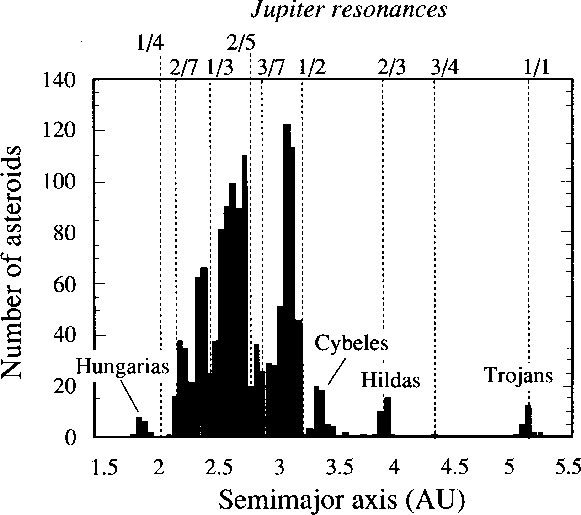

</div>

> **Figure 3:** The number of asteroids as a function of semi-major axis. Jupiter resonances are marked with vertical dotted lines, and four families are labeled. This plot is not based on DP0.3 and represents only real objects.

Compare Figure 3 with Figure 2 and notice that the Hildas, Cybeles, and Hungarias are clearly visible in the DP0.3 dataset.

We can also add the locations of the mean-motion resonances present in the main belt to our histogram above. We use Kepler's Third Law, (P/P_planet)^2 = (a/a_planet)^3, with the ratio of the orbital periods of the asteroid (`P`) and planet (`P_planet`) along with the semi-major axis of the planet (`a_planet`) to caclulate the semi-major axis at which the corresponding mean-motion resonance occurs: a_res = (P/P_planet)^(2/3) * a_planet. For example, the 3:1 mean-motion resonance with Jupiter, which corresponds to an asteroid orbital period that is 1/3 as long as Jupiter's orbital period, occurs at a_res = ((1/3)^0.66667 * (5.2 au) = 2.5 au.

In [ ]:
a_res_J_3_1 = calc_mean_motion_res_a((1/3), 5.2)
a_res_J_5_2 = calc_mean_motion_res_a((2/5), 5.2)
a_res_J_7_3 = calc_mean_motion_res_a((3/7), 5.2)
a_res_J_2_1 = calc_mean_motion_res_a((1/2), 5.2)
a_res_J_4_1 = calc_mean_motion_res_a((1/4), 5.2)
a_res_J_3_2 = calc_mean_motion_res_a((2/3), 5.2)

fig = plt.figure(figsize=(6, 4))

plt.hist(a[main_belt], bins=np.arange(1.6, 4.3, 0.01), color='Black')
plt.axvline(x=a_res_J_3_1, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(x=a_res_J_5_2, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(x=a_res_J_7_3, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(x=a_res_J_2_1, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(x=a_res_J_4_1, color='black', linestyle='dashed', linewidth=0.5)
plt.axvline(x=a_res_J_3_2, color='black', linestyle='dashed', linewidth=0.5)
plt.annotate('J 3:1', xy=(a_res_J_3_1-0.08, 5000.), xytext=(a_res_J_3_1-0.08, 4800.), rotation=90.0, fontsize=10)
plt.annotate('J 5:2', xy=(a_res_J_5_2-0.08, 5000.), xytext=(a_res_J_5_2-0.08, 4800.), rotation=90.0, fontsize=10)
plt.annotate('J 7:3', xy=(a_res_J_7_3-0.08, 5000.), xytext=(a_res_J_7_3-0.08, 4800.), rotation=90.0, fontsize=10)
plt.annotate('J 2:1', xy=(a_res_J_2_1-0.08, 5000.), xytext=(a_res_J_2_1-0.08, 4800.), rotation=90.0, fontsize=10)
plt.annotate('J 4:1', xy=(a_res_J_4_1-0.08, 5000.), xytext=(a_res_J_4_1-0.08, 4800.), rotation=90.0, fontsize=10)
plt.annotate('J 3:2', xy=(a_res_J_3_2-0.08, 5000.), xytext=(a_res_J_3_2-0.08, 4800.), rotation=90.0, fontsize=10)
plt.xlabel('semi-major axis (au)')
plt.ylabel('number of objects')
plt.minorticks_on()
plt.show()

> **Figure 4:** Same as Figure 2, but with Jupiter resonance lines added like in Figure 3.

Now we look at the main-belt asteroid's closest approach to the Sun in their orbits, known as the `perihelion distance (q)`:

In [ ]:
fig = plt.figure(figsize=(6, 4))

plt.hist(df_mpc_sso[main_belt].q, bins=np.arange(0.0, 4.3, 0.02),
         color='Black', log=True, histtype='step')
plt.xlabel('perihelion distance (au)')
plt.ylabel('number of objects')
plt.minorticks_on()
plt.show()

> **Figure 5:** The log number of objects as a function of perihelion distance.

Hmmm... Should we be concerned that some of those cross the Earth's orbit at 1 au(!)? That's left as an exercise for the learner to explore. (Note that Main Belt asteroids are by definition not going to approach the Earth, as they are typically defined to have perihelion distances beyond the orbit of Mars.)

#### 2.2.2 Orbital properties of Main Belt asteroids


<div style="max-width:250px;margin-right: auto; margin-right: 0;">

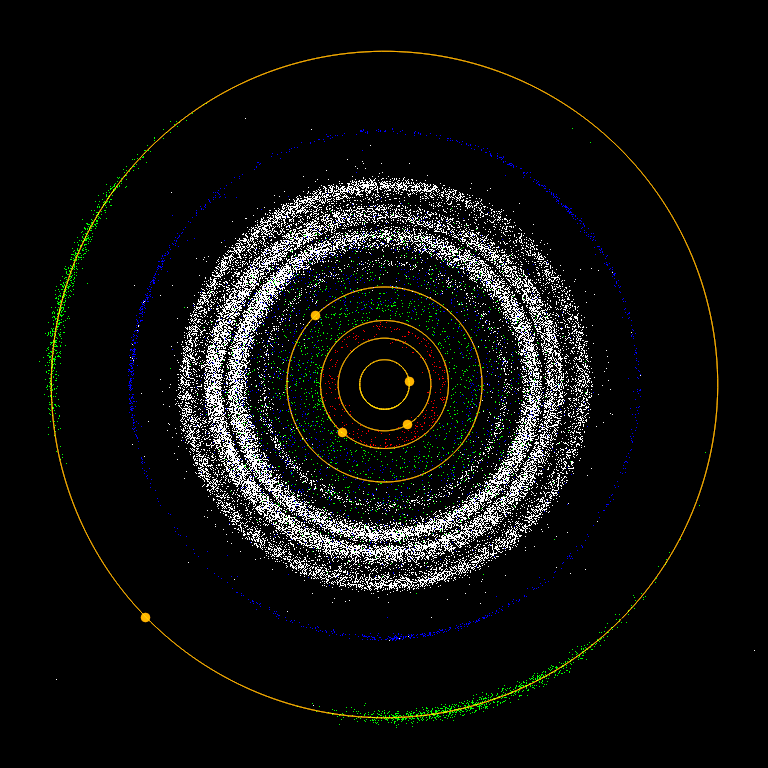

</div>

> **Figure 6:** The above illustration (from the Wikipedia article on [Kirkwood gaps](https://en.wikipedia.org/wiki/Kirkwood_gap)) shows planets as large orange circles, and asteroids as small dots of various colors. The Main Belt is clear as a large ring outside Mars' orbit (and inside Jupiter's), and you can clearly see the Kirkwood gaps in the Main Belt.

But we can go even further by classifying objects based on their orbital properties.

<div style="max-width:350px;margin-right: auto; margin-right: 0;">

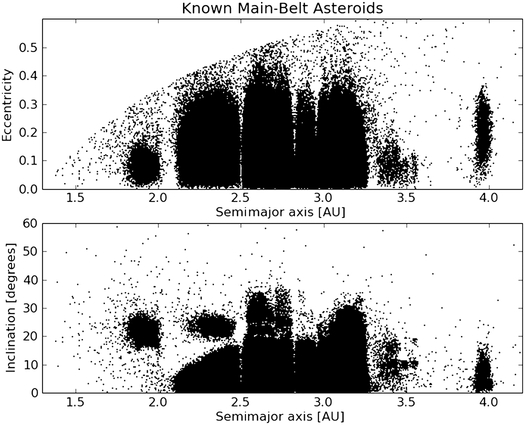

</div>

> **Figure 7:** The plot above is from the [Grav et al. 2011 paper](https://ui.adsabs.harvard.edu/abs/2011PASP..123..423G/abstract) describing the PanSTARRS Synthetic Solar System Model, which (in part) forms the basis of DP0.3's simulated dataset. This figure shows the orbital inclinations and eccentricities of "Main Belt asteroids" (according to that paper's definition of the Main Belt) as a function of their semi-major axis.

Let's make a similar plot for DP0.3 data and see how it compares to the earlier simulation. (First, we'll make the cut to remove objects with perihelia < 1.6 au.)

In [ ]:
not_near_mars_peri = df_mpc_sso.q > 1.6

Now plot the properties of these selected objects. Note that because DP0.3 (and, ultimately, LSST) has far more detected asteroids than previous SDSS-based studies, we will need to plot density of points instead of a scatter plot. Thus, in each of the following plots, the color scale represents the number of points, from purple/blue as the fewest to red regions containing the most objects.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)

im0 = axs[0].hexbin(a[not_near_mars_peri],
                    np.sin(np.deg2rad(df_mpc_sso[not_near_mars_peri].incl)),
                    gridsize=(int(4.7/0.01), 200),
                    cmap='Spectral_r', bins='log',
                    extent=(0, 4.7, 0, 1))
axs[0].set_ylabel('sin(incl)')
axs[0].minorticks_on()
axs[0].set_xlim(0, 103)

im1 = axs[1].hexbin(a[not_near_mars_peri],
                    df_mpc_sso[not_near_mars_peri].e,
                    gridsize=(int(4.7/0.01), 200),
                    cmap='Spectral_r', bins='log',
                    extent=(0, 4.7, 0, 1))
axs[1].set_ylabel('eccentricity')
axs[1].set_xlabel('semi-major axis (au)')

axs[1].set_xlim(1.2, 4.7)
axs[1].set_ylim(0, 1.09)
axs[1].minorticks_on()
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()
plt.close()

> **Figure 8:** Similar to Figure 1, but for Main Belt asteroids only.

## 3. Orbit families among Main Belt asteroids

Besides the Kirkwood gaps, the distribution of asteroids in the above plot clearly shows concentrations ("blobs") of objects that share similar orbital properties. Let's examine those in more detail.


<div style="max-width:300px;margin-right: auto; margin-right: 0;">

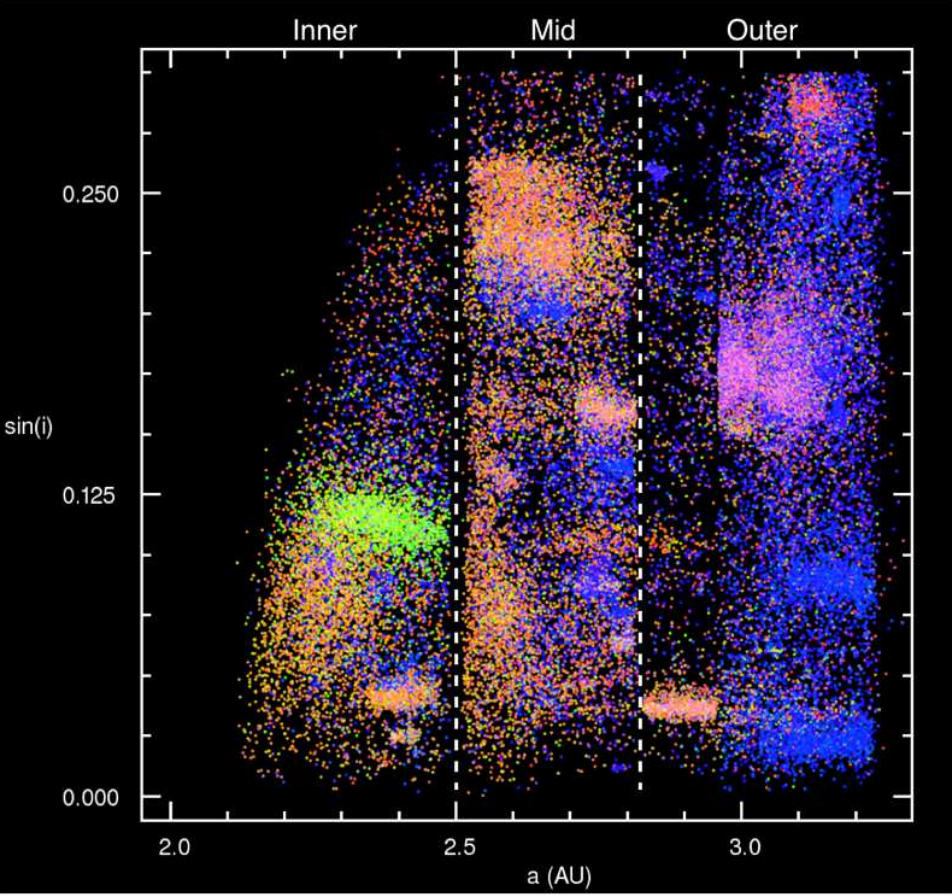

</div>

> **Figure 9** Inclination versus semi-major axis of Main Belt asteroids from SDSS, from [Parker et al. 2008](https://ui.adsabs.harvard.edu/abs/2008Icar..198..138P/abstract). (See also [Ivezic et al. 2002](https://ui.adsabs.harvard.edu/abs/2002AJ....124.2943I/abstract) and Chapter 5 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).)


<div style="max-width:600px;margin-right: auto; margin-right: 0;">

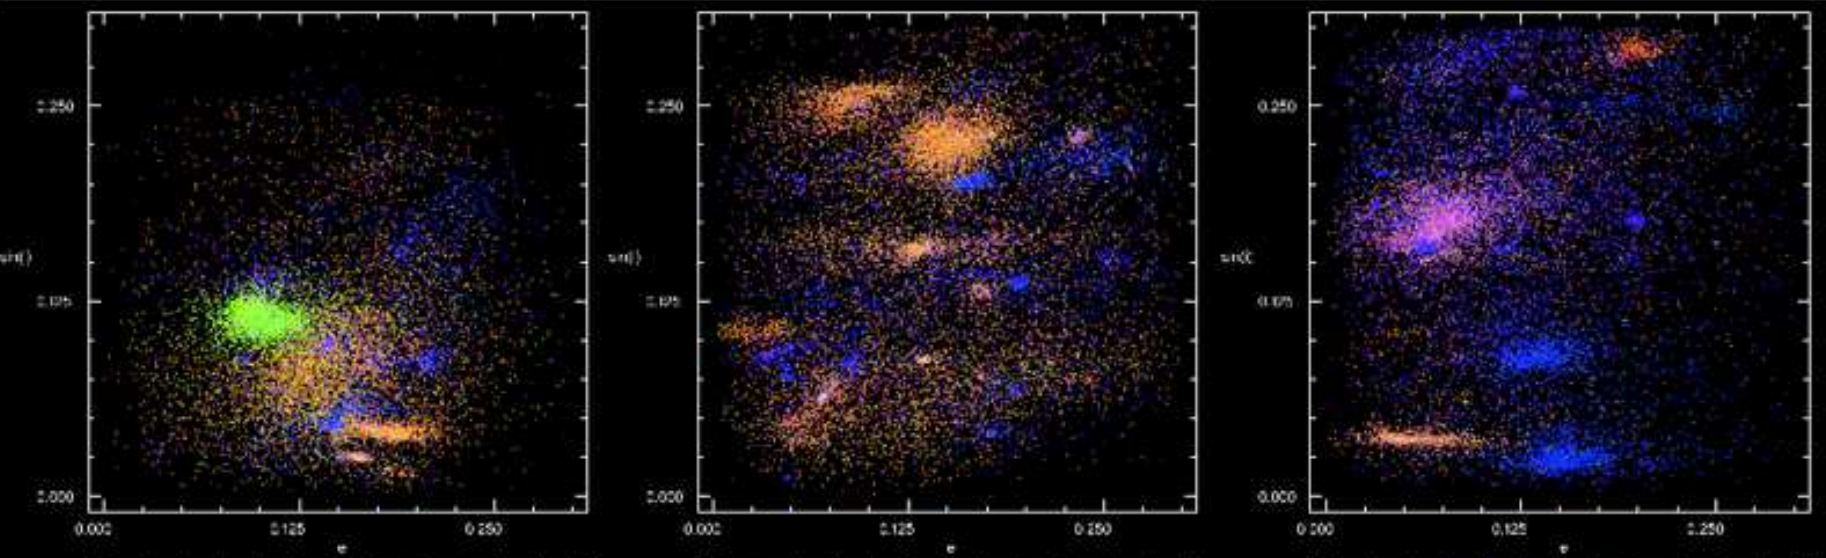

</div>

> **Figure 10:** Inclination versus eccentricity for Main Belt asteroids in the inner- (left), mid- (center), and outer-belt (right) from SDSS (Parker et al. 2008). The resolution of this plot is low but the x-axis is "e" and y-axis is "sin(i)".

Below, divide the Main Belt asteroids into the following subsets:
- inner belt: 2.0 < a < 2.5 au
- mid belt: 2.5 < a < 2.82 au
- outer belt: 2.82 < a < 3.25 au

In [ ]:
inner_belt = (a > 2.0) & (a < 2.5) & not_near_mars_peri
mid_belt = (a >= 2.5) & (a < 2.82) & not_near_mars_peri
outer_belt = (a > 2.82) & (a < 3.25) & not_near_mars_peri

Plot `sin(incl)` (inclination) vs. `eccentricity (e)` to compare to Figure 10.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)),
              gridsize=300, bins='log', cmap='Spectral_r')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].minorticks_on()
axs[0].set_title(r'inner belt (2.0 < a < 2.5)', fontsize=16)

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)),
              gridsize=300, bins='log', cmap='Spectral_r')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].minorticks_on()
axs[1].set_title(r'mid belt (2.5 < a < 2.82)', fontsize=16)

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)),
              gridsize=300, bins='log', cmap='Spectral_r')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 1)
axs[2].minorticks_on()
axs[2].set_title(r'outer belt (2.82 < a < 3.25)', fontsize=16)

plt.show()

> **Figure 11:** Inclination versus eccentricity for Main Belt asteroids in the inner- (left), mid- (center), and outer-belt (right) from DP0.3. Compare with Figure 10 from SDSS. As in Figure 1 and 8, objects are binned and the colors purple to red represent lower to higher numbers of objects.

As you could see in the plot from the Parker et al. paper above, most of the "blobs" are at low inclinations and low eccentricities. Zoom in on the lower-left portion:

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 0.275)
axs[0].set_ylim(0, 0.275)
axs[0].minorticks_on()

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 0.275)
axs[1].set_ylim(0, 0.275)
axs[1].minorticks_on()

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 0.275)
axs[2].set_ylim(0, 0.275)
axs[2].minorticks_on()

plt.show()


> **Figure 12:** A zoom in on the lower right corners of Figure 11, to better match the axes limits of Figure 10, for comparison.

<div style="max-width:600px;margin-right: auto; margin-right: 0;">

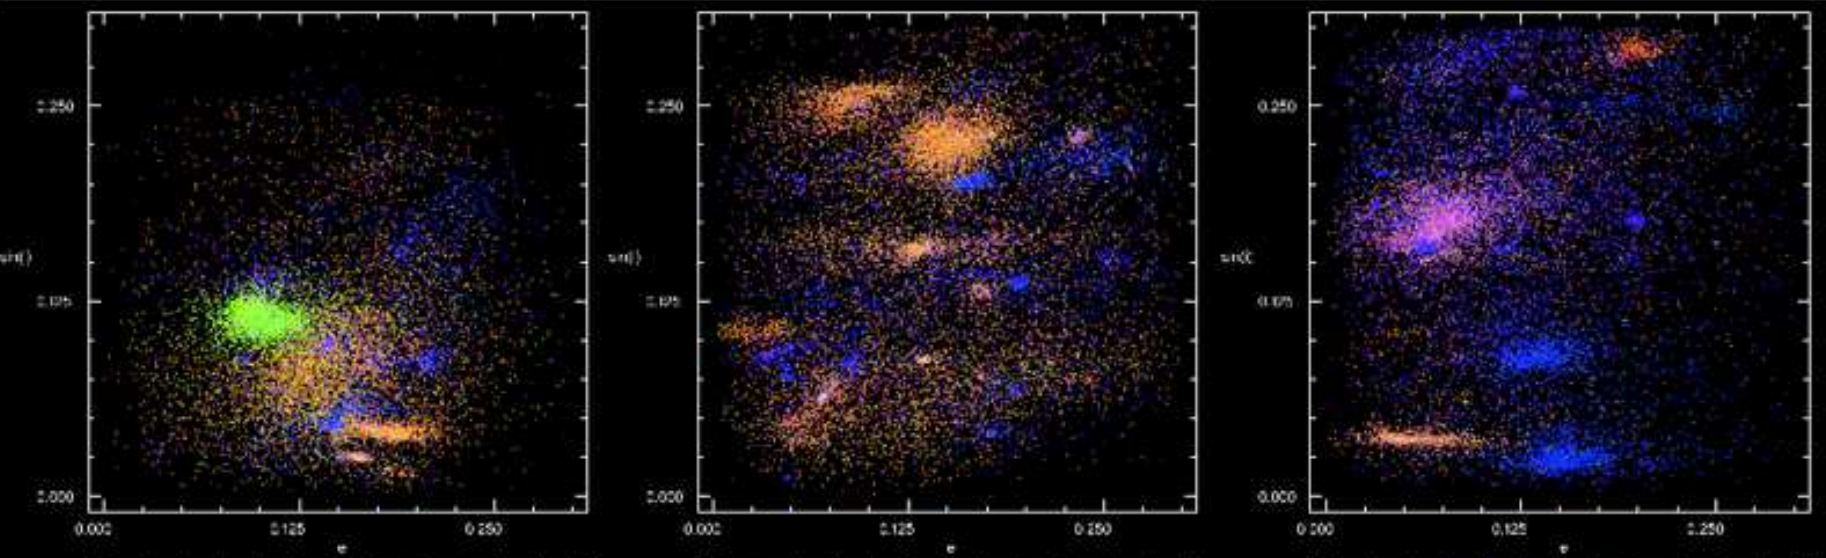

</div>

> **Figure 13:** A repeat of Figure 10, to enable direct visual comparison with Figure 12 above.

Above, see that many of the same features are present. One could look into those features in more detail (indeed, many of them are _named_ orbital families), but that is beyond the scope of this notebook.

Finally, to give some intuition about what the actual _orbits_ of these orbital families look like, we will plot them in heliocentric (Sun-centered) Cartesian (XYZ) coordinates. We'll plot 10 randomly-selected objects from "blobs" (i.e., orbital families) in the inner, mid, and outer belts in three separate plots.

Create a plot overlaying the boxes to select objects from.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].hexbin(df_mpc_sso[inner_belt].e, np.sin(np.deg2rad(df_mpc_sso[inner_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[0].plot([0.1, 0.1, 0.15, 0.15, 0.1], [0.09, 0.13, 0.13, 0.09, 0.09], color='Black')
axs[0].set_xlabel('e')
axs[0].set_ylabel('sin(i)')
axs[0].set_xlim(0, 0.275)
axs[0].set_ylim(0, 0.275)
axs[0].minorticks_on()

axs[1].hexbin(df_mpc_sso[mid_belt].e, np.sin(np.deg2rad(df_mpc_sso[mid_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[1].plot([0.15, 0.15, 0.2, 0.2, 0.15], [0.21, 0.25, 0.25, 0.21, 0.21], color='Black')
axs[1].set_xlabel('e')
axs[1].set_xlim(0, 0.275)
axs[1].set_ylim(0, 0.275)
axs[1].minorticks_on()

axs[2].hexbin(df_mpc_sso[outer_belt].e, np.sin(np.deg2rad(df_mpc_sso[outer_belt].incl)),
              gridsize=200, bins='log', cmap='Spectral_r')
axs[2].plot([0.04, 0.04, 0.1, 0.1, 0.04], [0.15, 0.2, 0.2, 0.15, 0.15], color='Black')
axs[2].set_xlabel('e')
axs[2].set_xlim(0, 0.275)
axs[2].set_ylim(0, 0.275)
axs[2].minorticks_on()

plt.show()

> **Figure 14:** Same as Figure 12, but with open black squares marking the high-density locations to be used below.

The following three cells below pick 10 objects at random, then use the `get_obj_matched` function defined above to select all measurements of each object from the SSSource table.

In [ ]:
inner_blob = (df_mpc_sso.e > 0.1) & (df_mpc_sso.e < 0.15) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.13) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.09)

nobj_to_plot = 10
pick_obj_inner = df_mpc_sso[inner_belt & inner_blob].sample(nobj_to_plot)

pick_obj_torb_inner = []
pick_obj_x_inner = []
pick_obj_y_inner = []
pick_obj_z_inner = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_inner.ssObjectId.values[i])
    pick_obj_torb_inner.append(src_cat_obj['midPointMjdTai'])
    pick_obj_x_inner.append(src_cat_obj['heliocentricX'])
    pick_obj_y_inner.append(src_cat_obj['heliocentricY'])
    pick_obj_z_inner.append(src_cat_obj['heliocentricZ'])

In [ ]:
mid_blob = (df_mpc_sso.e > 0.15) & (df_mpc_sso.e < 0.2) & \
           (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.25) & \
           (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.21)

nobj_to_plot = 10
pick_obj_mid = df_mpc_sso[mid_belt & mid_blob].sample(nobj_to_plot)

pick_obj_torb_mid = []
pick_obj_x_mid = []
pick_obj_y_mid = []
pick_obj_z_mid = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_mid.ssObjectId.values[i])
    pick_obj_torb_mid.append(src_cat_obj['midPointMjdTai'])
    pick_obj_x_mid.append(src_cat_obj['heliocentricX'])
    pick_obj_y_mid.append(src_cat_obj['heliocentricY'])
    pick_obj_z_mid.append(src_cat_obj['heliocentricZ'])

In [ ]:
outer_blob = (df_mpc_sso.e > 0.04) & (df_mpc_sso.e < 0.1) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) < 0.2) & \
             (np.sin(np.deg2rad(df_mpc_sso.incl)) > 0.15)

nobj_to_plot = 10
pick_obj_outer = df_mpc_sso[outer_belt & outer_blob].sample(nobj_to_plot)

pick_obj_torb_outer = []
pick_obj_x_outer = []
pick_obj_y_outer = []
pick_obj_z_outer = []

for i in range(nobj_to_plot):
    src_cat_obj = get_obj_matched(pick_obj_outer.ssObjectId.values[i])
    pick_obj_torb_outer.append(src_cat_obj['midPointMjdTai'])
    pick_obj_x_outer.append(src_cat_obj['heliocentricX'])
    pick_obj_y_outer.append(src_cat_obj['heliocentricY'])
    pick_obj_z_outer.append(src_cat_obj['heliocentricZ'])

The next three cells use the orbit plotting function we defined above to plot them.

In [ ]:
xyz_orbit_plot_manyobjects(pick_obj_torb_inner, pick_obj_x_inner,
                           pick_obj_y_inner, pick_obj_z_inner, title='inner')

> **Figure 15:** Projections of the detections of 10 inner-belt asteroids in the ZX (top left), ZY (top right), and YX (bottom) planes of the solar system.

In [ ]:
xyz_orbit_plot_manyobjects(pick_obj_torb_mid, pick_obj_x_mid,
                           pick_obj_y_mid, pick_obj_z_mid, title='mid')

> **Figure 16:** Similar to Figure 15, but for mid-belt asteroids.

In [ ]:
xyz_orbit_plot_manyobjects(pick_obj_torb_outer, pick_obj_x_outer,
                           pick_obj_y_outer, pick_obj_z_outer, title='outer')

> **Figure 17:** Similar to Figure 15, but for outer-belt asteroids.

In the above three plots there are small differences between the orbits of these families, but nothing dramatic. (Though that may not be surprising given how similar the inclinations and eccentricities of the different families we selected were in the first place.) More exploration would be required to really understand and classify the different families.

## 4. Exercises for the learner

1. Explore the properties of other families in the Main Belt. Do their orbits look different than the ones we've examined so far?

2. Figure out whether the objects seen in Section 2.2.1 with perihelion distance less than 1.6 au (i.e., ones that travel inside the orbit of Mars) make a close approach to the Earth or Mars.

3. Compare properties of Main Belt asteroids with those elsewhere in the Solar System.